<a href="https://colab.research.google.com/github/MrinalRabha/PINN_1D_heat/blob/main/1D_heat_PINN_1_contour.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Epoch 500/10000, Total Loss=0.002940, PDE_res=0.001052, IC_res=0.000824, BC1_res=0.000223, BC2_res=0.000841
Epoch 1000/10000, Total Loss=0.000099, PDE_res=0.000011, IC_res=0.000025, BC1_res=0.000011, BC2_res=0.000052
Epoch 1500/10000, Total Loss=0.003504, PDE_res=0.000101, IC_res=0.000617, BC1_res=0.001405, BC2_res=0.001381
Epoch 2000/10000, Total Loss=0.000114, PDE_res=0.000029, IC_res=0.000028, BC1_res=0.000008, BC2_res=0.000049
Epoch 2500/10000, Total Loss=0.000052, PDE_res=0.000008, IC_res=0.000023, BC1_res=0.000006, BC2_res=0.000015
Epoch 3000/10000, Total Loss=0.000958, PDE_res=0.000076, IC_res=0.000341, BC1_res=0.000348, BC2_res=0.000193
Epoch 3500/10000, Total Loss=0.000041, PDE_res=0.000004, IC_res=0.000019, BC1_res=0.000003, BC2_res=0.000015
Epoch 4000/10000, Total Loss=0.000035, PDE_res=0.000003, IC_res=0.000016, BC1_res=0.000003, BC2_res=0.000013
Epoch 4500/10000, Total Loss=0.000139, PDE_res=0.000013, IC_res=0.000037, BC1_res=0.000031, BC2_res=0.000057
Epoch 5000/10000, To

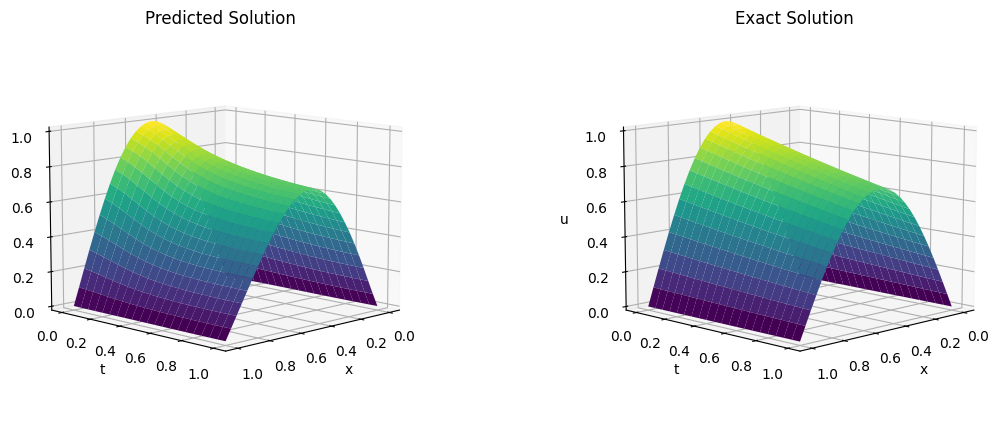

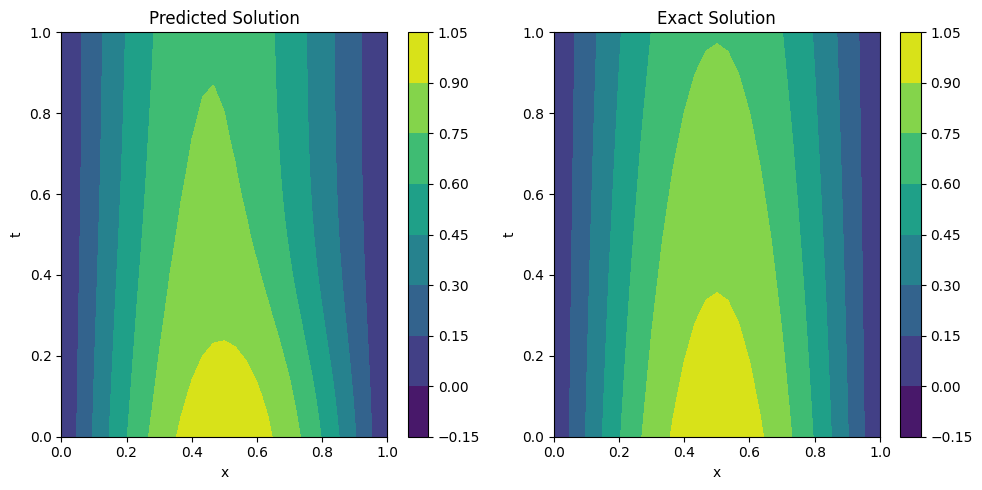

In [3]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

# Constants
D = 0.03
NUM_IC_POINTS = 200  # Increased number of points for initial condition

# True solution function
def true_solution(x, t):
    return (torch.exp(-((torch.pi)**2) * D * t)) * torch.sin(torch.pi * x)

# Create spatial and temporal points
x = torch.linspace(0, 1, 100, requires_grad=True)
t = torch.linspace(0, 1, 100, requires_grad=True)

# Define the PINN model
class PINN(nn.Module):
    def __init__(self):
        super(PINN, self).__init__()
        self.hidden_layer1 = nn.Linear(2, 20)
        self.hidden_layer2 = nn.Linear(20, 20)
        self.hidden_layer3 = nn.Linear(20, 20)
        self.hidden_layer4 = nn.Linear(20, 20)
        self.hidden_layer5 = nn.Linear(20, 20)
        self.output_layer = nn.Linear(20, 1)

    def forward(self, x, t):
        x = x.reshape(-1, 1)
        t = t.reshape(-1, 1)
        inputs = torch.concat([x, t], dim=1)
        layer1_out = torch.tanh(self.hidden_layer1(inputs))
        layer2_out = torch.tanh(self.hidden_layer2(layer1_out))
        layer3_out = torch.tanh(self.hidden_layer3(layer2_out))
        layer4_out = torch.tanh(self.hidden_layer4(layer3_out))
        layer5_out = torch.tanh(self.hidden_layer5(layer4_out))
        output = self.output_layer(layer5_out)
        return output

model = PINN()

# Auto-differentiation function
def derivative(y, x):
    return torch.autograd.grad(
        y, x,
        grad_outputs=torch.ones_like(y),
        create_graph=True
    )[0]

# Define loss functions
def pde_res(model, x, t):
    t.requires_grad_(True)
    x.requires_grad_(True)
    u_pred = model(x, t)
    du_dt_pred = derivative(u_pred, t)
    du_dx_pred = derivative(u_pred, x)
    du2_dx2_pred = derivative(du_dx_pred, x)
    pde_res = torch.mean((du_dt_pred-D*du2_dx2_pred) ** 2)
    return pde_res

def ic_res(model):
    global x
    t0 = torch.zeros(NUM_IC_POINTS, 1, dtype=torch.float32, requires_grad=False)
    x_ic = torch.linspace(0, 1, NUM_IC_POINTS, requires_grad=True).reshape(-1, 1)
    u_x_t0 = model(x_ic, t0)
    return torch.mean((u_x_t0 - torch.sin((torch.pi) * x_ic)) ** 2)

def bc1_res(model):
    global t
    x0 = torch.zeros(t.shape[0], 1, dtype=torch.float32, requires_grad=False)
    u_x0_t = model(x0, t)
    return torch.mean((u_x0_t) ** 2)

def bc2_res(model):
    global t
    x1 = torch.ones(t.shape[0], 1, dtype=torch.float32, requires_grad=False)
    u_x1_t = model(x1, t)
    return torch.mean((u_x1_t) ** 2)

# Training setup
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
num_epochs = 10000
print_every = 500

# Training loop
model.train()
for epoch in range(num_epochs):
    optimizer.zero_grad()

    l_pde = pde_res(model, x, t)
    l_ic = ic_res(model)
    l_bc1 = bc1_res(model)
    l_bc2 = bc2_res(model)

    # Weighting the initial condition loss
    loss = l_pde + l_ic + l_bc1 + l_bc2  # Weighting IC loss

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Print progress
    if (epoch + 1) % print_every == 0:
        print(f"Epoch {epoch + 1}/{num_epochs}, "
              f"Total Loss={loss.item():.6f}, "
              f"PDE_res={l_pde.item():.6f}, "
              f"IC_res={l_ic.item():.6f}, "
              f"BC1_res={l_bc1.item():.6f}, "
              f"BC2_res={l_bc2.item():.6f}")

# Evaluate the trained model
model.eval()

#plot
print("plot :")
Nx, Nt = 31, 21
x = torch.linspace(0, 1, Nx)
t = torch.linspace(0, 1, Nt)

x, t = torch.meshgrid(x, t, indexing="ij")
x = x.reshape(-1, 1)
t = t.reshape(-1, 1)
x_t = torch.cat((x, t), 1)

exact = ((torch.exp(-((torch.pi)**2)*D*t))*torch.sin(torch.pi*x)).reshape(Nx,Nt)
predict = model(x,t).reshape(Nx, Nt)
x = x.reshape(Nx, Nt)
t = t.reshape(Nx, Nt)

fig = plt.figure(figsize=(21, 5))
ax = fig.add_subplot(131, projection="3d")
ax.plot_surface(x, t, predict.detach().numpy(), cmap="viridis")
ax.view_init(10, 45)
ax.set_title("Predicted Solution")
ax.set_xlabel("x")
ax.set_ylabel("t")
ax.set_zlabel("u")

ax = fig.add_subplot(132, projection="3d")
ax.plot_surface(x, t, exact.detach().numpy(), cmap="viridis")
ax.view_init(10, 45)
ax.set_title("Exact Solution")
ax.set_xlabel("x")
ax.set_ylabel("t")
ax.set_zlabel("u")

Nx, Nt = 31, 21
x = torch.linspace(0, 1, Nx)
t = torch.linspace(0, 1, Nt)

x, t = torch.meshgrid(x, t, indexing="ij")
x = x.reshape(-1, 1)
t = t.reshape(-1, 1)

exact = ((torch.exp(-((torch.pi)**2)*D*t))*torch.sin(torch.pi*x)).reshape(Nx,Nt)
predict = model(x,t).reshape(Nx, Nt)
x = x.reshape(Nx, Nt)
t = t.reshape(Nx, Nt)

# Create contour plots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

# Predicted solution contour plot
contour1 = ax1.contourf(x.detach().numpy(), t.detach().numpy(), predict.detach().numpy(), cmap="viridis")
ax1.set_xlabel("x")
ax1.set_ylabel("t")
ax1.set_title("Predicted Solution")
fig.colorbar(contour1, ax=ax1)

# Exact solution contour plot
contour2 = ax2.contourf(x.detach().numpy(), t.detach().numpy(), exact.detach().numpy(), cmap="viridis")
ax2.set_xlabel("x")
ax2.set_ylabel("t")
ax2.set_title("Exact Solution")
fig.colorbar(contour2, ax=ax2)

plt.tight_layout()
plt.show()
